## Análisis Multivariado de Señales Sismográficas

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

2021


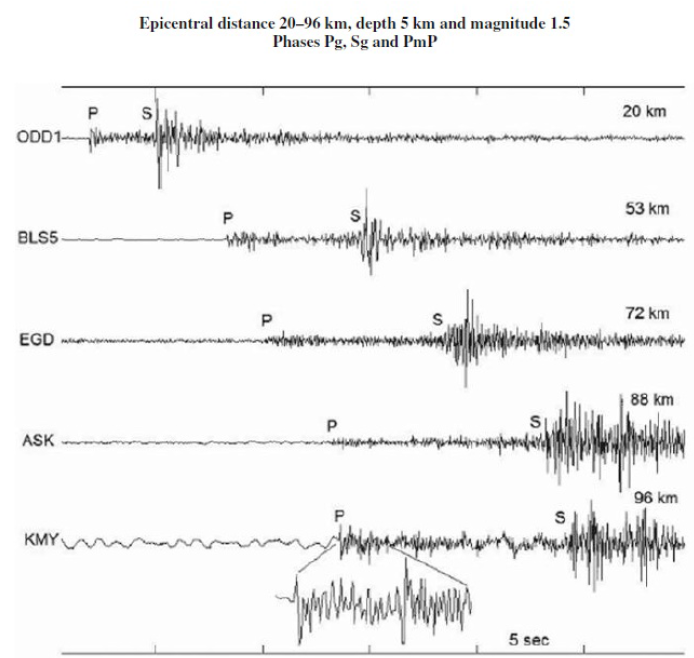

Los observatorios sismológicos clasifican las señales sísmicas de acuerdo a la diferencia de tiempo de arribo entre la onda P y la onda S, conocida como S-P. La S-P, es una indicación de la distancia que existe desde el punto donde se genera el sismo al punto donde se encuentra la estación que lo registra, es decir de la distancia epicentral. Dicho parámetro, aplicado a las señales registradas
por el OSQ permite definir tres tipos de sismos: local, caracterizado por tener una S-P menor a 20 s; regional cuya S-P varía entre 20 s y 180 s y telesismo, cuya S-P es mayor 180 s.

In [1]:
!pip install pyts

     |████████████████████████████████| 2.5MB 7.7MB/s 


In [2]:
#!wget 'https://github.com/hernanfgarcia/TSIII_20211/blob/main/sisLoc.mat'
#!wget 'https://github.com/hernanfgarcia/TSIII_20211/blob/main/sisTele.mat'
#!wget 'https://github.com/hernanfgarcia/TSIII_20211/blob/main/sisReg.mat'

In [3]:
%ls

sample_data/


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
import scipy.io as sc
from scipy.signal import stft, bode, butter, lfilter, freqz


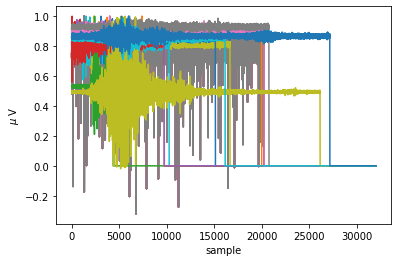

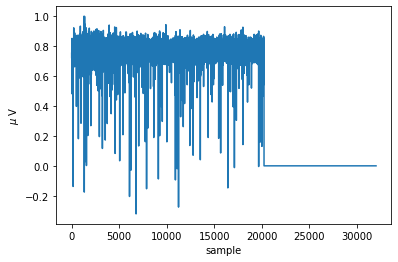

In [39]:
#Por ahora estoy probando solo con sisTele.mat
data = sc.loadmat('/content/gdrive/MyDrive/MiniProyecto1/sisTele.mat')
data.keys() # variables del diccionario

Y = data['Y']
fs = data['fs']

plt.plot(Y.T)
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.show()
sampleSignal = Y[0,:] # se extrae una señal de la base de datos
plt.figure
plt.plot(sampleSignal)
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.show()

<Figure size 432x288 with 0 Axes>

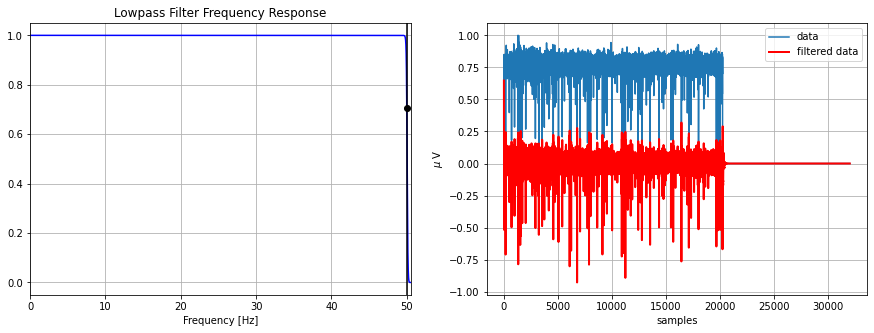

In [41]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 101.0      # sample rate, Hz
cutoff1 = 1
cutoff = 50  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.figure()
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

data = sampleSignal

# Filter the data, and plot both the original and filtered signals.
#y = butter_lowpass_filter(data, cutoff, fs, order)
y = butter_bandpass_filter(data, cutoff1, cutoff, fs, order=5)

plt.subplot(1, 2, 2)
plt.plot(data, label='data')
plt.plot(y, 'r-', linewidth=2, label='filtered data')
plt.xlabel('samples')
plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

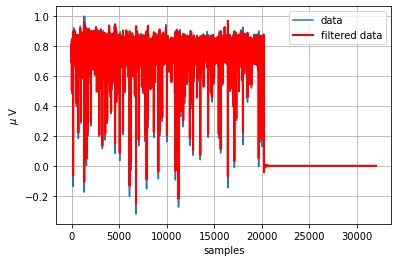

In [34]:
# Filter requirements.
order = 6 # Filter oder.
fs = 101.0 # Sample rate, Hz.
cutoff1 = 1
cutoff = 50 # Desired cutoff frequency of the filter, Hz.

Yfiltered = np.zeros( (21, 32000) )
for i in range(0, 21):
  Yfiltered[i,:] = butter_lowpass_filter(Y[i,:], cutoff, fs, order)
  #print(i)
  #print(Yfiltered[i,:10])

nonfiltdata = Y[0,:]
filtdata = Yfiltered[0,:]

# Filter the data, and plot both the original and filtered signals.
plt.plot(nonfiltdata, label='data')
plt.plot(filtdata, 'r-', linewidth=2, label='filtered data')
plt.xlabel('samples')
plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

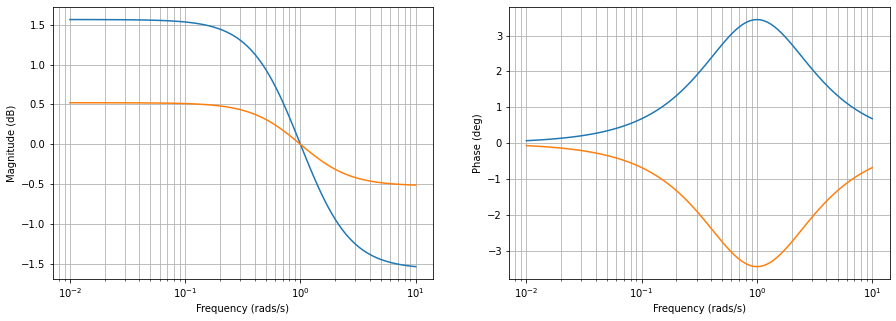

In [38]:
b, a = butter_bandpass(cutoff1, cutoff, fs, order)
b1, a1 = butter_lowpass(cutoff, fs, order)

sys = (b, a)
sys1 = (b1, a1)

w, mag, phase = bode(sys)
w1, mag1, phase1 = bode(sys1)


plt.figure()
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.semilogx(w, mag) # Bode magnitude plot. bandpass
plt.semilogx(w1, mag1) # Bode magnitude plot. lowpass
plt.xlabel('Frequency (rads/s)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, which="both")

plt.subplot(1, 2, 2)
plt.semilogx(w, phase) # Bode phase plot. bandpass
plt.semilogx(w1, phase1) # Bode magnitude plot. lowpass
plt.xlabel('Frequency (rads/s)') 
plt.ylabel('Phase (deg)')
plt.grid(True, which="both")


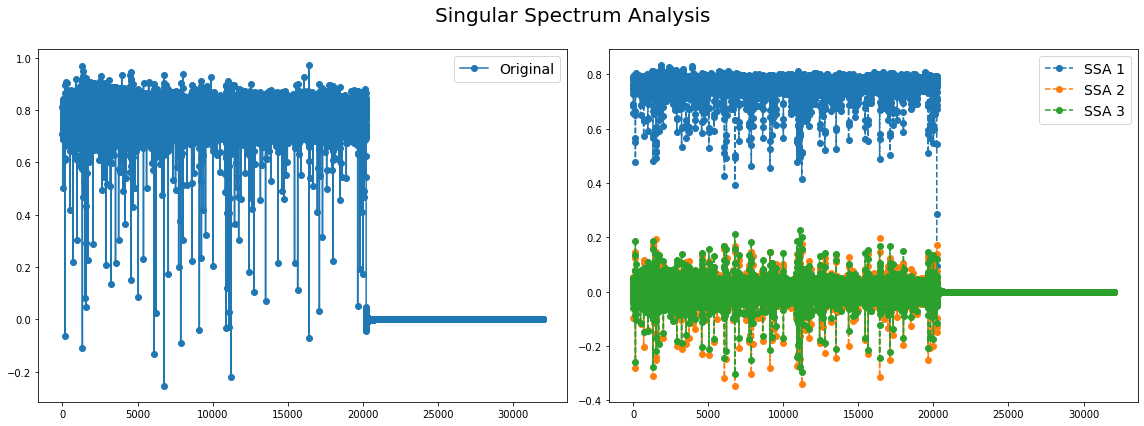

In [10]:
X = Yfiltered # Conjunto de 21 sismos (filtrados).
groups = 3 # Conjunto de señales subyacentes.
ssa = SingularSpectrumAnalysis(window_size=groups) # Singular Spectrum Analysis.
X_ssa = ssa.fit_transform(X) # Matríz con las nuevas señales subyacentes.

# Show the results for the first time series and its subseries.
plt.figure(figsize=(16, 6))
idSignal = 0 # Identificador de la señal seleccionada (de las 21).
plt.suptitle('Singular Spectrum Analysis', fontsize=20)
ax1 = plt.subplot(121)
ax1.plot(X[idSignal], 'o-', label='Original')
ax1.legend(loc='best', fontsize=14)

ax2 = plt.subplot(122)
for i in range(groups):
    ax2.plot(X_ssa[idSignal, i], 'o--', label='SSA {0}'.format(i + 1))
ax2.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

# The first subseries consists of the trend of the original time series.
# The second and third subseries consist of noise.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f246c6613d0>,
 [<matplotlib.lines.Line2D at 0x7f246af22d50>])

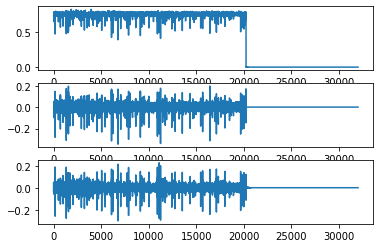

In [11]:
plt.subplot(3,1,1),plt.plot(X_ssa[idSignal, 0])
plt.subplot(3,1,2),plt.plot(X_ssa[idSignal, 1])
plt.subplot(3,1,3),plt.plot(X_ssa[idSignal, 2])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


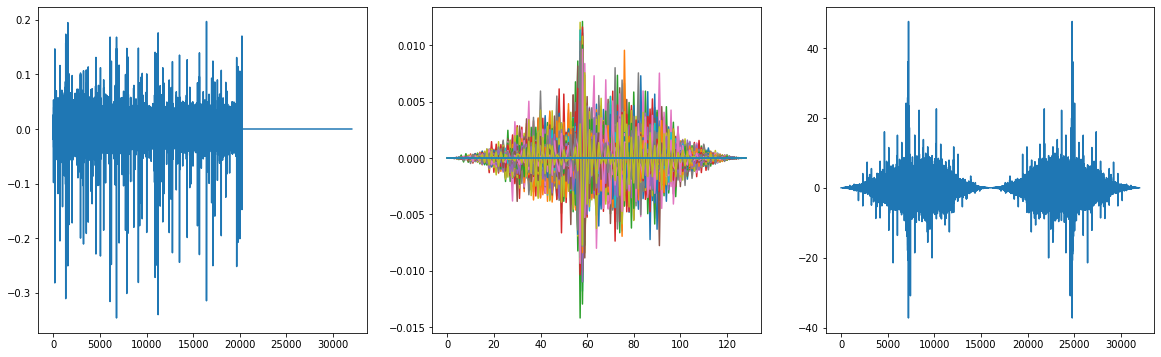

In [12]:
testsig=X_ssa[0,1]; plt.figure(figsize=(20, 6))
plt.subplot(1,3,1); plt.plot(testsig);
f, t, Zxx = stft(testsig, fs)
plt.subplot(1,3,2); plt.plot(Zxx);
fr = np.fft.fft(testsig)
plt.subplot(1,3,3); plt.plot(fr);


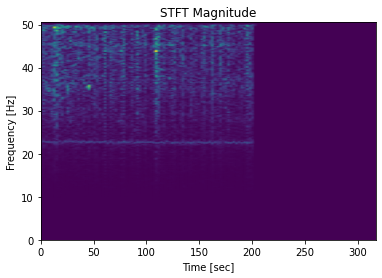

In [43]:
# Calculemos la STFT
from scipy import signal
f, t, Zxx = signal.stft(X_ssa[0,2], fs, nperseg=512)

absZxx = np.abs(Zxx)
plt.pcolormesh(t, f, absZxx, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

A partir de lo anterior podemos analizar que el espectrograma de la STFT va a permitirnos analizar los cambios de señales no estacionarias.

"En la práctica, el procedimiento para calcular la STFT es dividir una señal de tiempo en segmentos más cortos de igual longitud y luego calcular la transformada de Fourier por separado en cada segmento más corto."

In [14]:
# Dado que en Zxx queda el espectro para cada uno de estos segmentos analizaremos las características de estos
# En cada Fila de Zxx tendremos la FFT de cada segmento
# Asi que:
MaxSpectro = np.max(absZxx)
idFrecMax = np.where(absZxx==MaxSpectro) # Posición i, j de la matriz absZxx donde i: frec, j: time
frecPMax = f[idFrecMax[0]]
print('max(|Zxx| = ',MaxSpectro,'dB\nFmax at maxPower: ',frecPMax,'Hz')

max(|Zxx| =  0.011738798148150298 dB
Fmax at maxPower:  [43.99023438] Hz


## DataFrames en PANDAS

In [15]:
import pandas as pd

d = {"one": pd.Series([1.0, 2.0, 3.0], index=["a", "b", "c"]),
       "two": pd.Series([1.0, 2.0, 3.0, 4.0], index=["a", "b", "c", "d"]),
     }
 

df = pd.DataFrame(d)

In [16]:
df

,one,two
a,1.0,1.0
b,2.0,2.0
c,3.0,3.0
d,NaN,4.0


In [17]:
import seaborn as sns

penguins = sns.load_dataset("penguins")

In [18]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


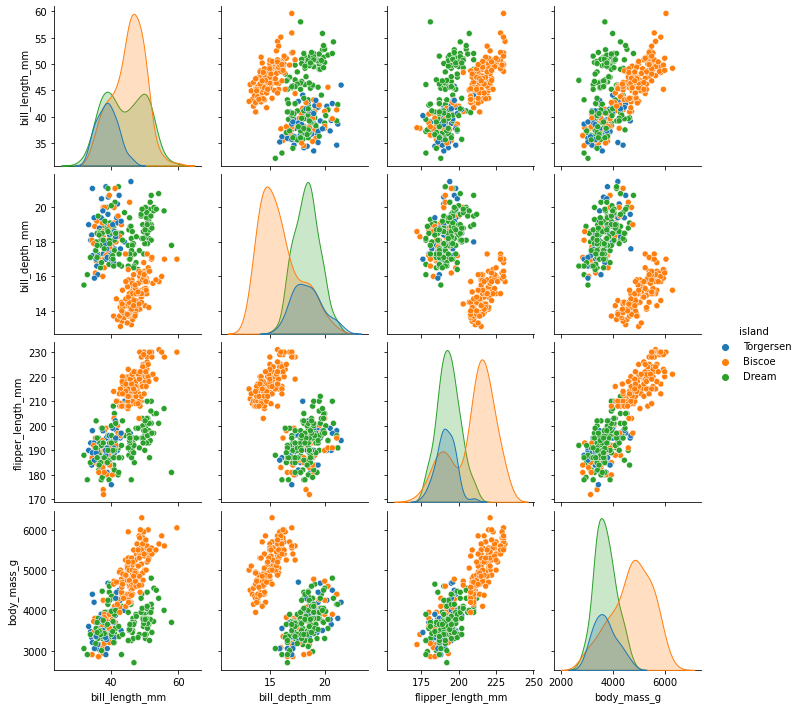

In [19]:
sns.pairplot(penguins, hue="island")

## Numpy Array to DataFrame

In [20]:
X = np.random.randn(63,7)
print(X)

[[ 8.84541297e-01 -3.37292519e-01 -2.73555748e-01 -2.98520585e-01
   5.17098666e-01 -8.64144724e-01 -3.77523498e-01]
 [ 1.23643159e+00  4.42309414e-01 -5.60842249e-01 -8.34193288e-01
   1.35592241e+00  4.13756345e-01 -2.51864282e+00]
 [-1.20676985e+00  5.47024543e-01  2.17232420e-01  1.93707629e-01
   1.37515863e+00 -5.30805013e-01 -3.13505828e-02]
 [ 1.04448664e+00  8.68839257e-02  1.12511528e-01 -6.16276508e-01
   1.28096194e+00  1.55748842e+00 -5.61755415e-01]
 [ 1.12083511e+00 -2.04964579e+00 -6.98041294e-01 -2.34844664e+00
   1.63377523e+00 -4.07768286e-01  3.33070783e-02]
 [ 4.53950691e-01  7.57267397e-03  2.47169865e-01 -1.20320556e+00
  -6.80596073e-01  5.36493533e-01  6.22276102e-01]
 [ 1.53857333e+00  2.31832265e-01  1.01640681e-01 -1.82068389e+00
  -7.48539561e-01 -1.68271789e-01 -2.79475892e-01]
 [ 7.94532081e-01  1.57848223e+00  1.26539554e+00  1.57490265e+00
  -8.57957133e-01 -6.30311408e-02  9.32776782e-01]
 [-2.05640546e-01  2.81392183e-01  1.18235503e+00  5.88910267e-0

In [21]:
# Dataframe de un nparray
df = pd.DataFrame(X,columns=['Energia','Potencia','F_Pmax','Media','Var','Max','Min'])

In [22]:
df

,Energia,Potencia,F_Pmax,Media,Var,Max,Min
0,0.884541,-0.337293,-0.273556,-0.298521,0.517099,-0.864145,-0.377523
1,1.236432,0.442309,-0.560842,-0.834193,1.355922,0.413756,-2.518643
2,-1.206770,0.547025,0.217232,0.193708,1.375159,-0.530805,-0.031351
3,1.044487,0.086884,0.112512,-0.616277,1.280962,1.557488,-0.561755
4,1.120835,-2.049646,-0.698041,-2.348447,1.633775,-0.407768,0.033307
...,...,...,...,...,...,...,...
58,-0.559138,-1.516426,0.070311,1.790993,1.794090,-0.940124,-0.354807
59,0.114396,-0.743473,-2.125529,-0.517469,-0.592465,-1.061435,-0.302699
60,1.123750,0.564484,0.593915,-0.125788,0.854764,-0.484796,0.094950
61,-1.915976,0.957869,-0.561787,-0.508842,-0.588411,0.332737,1.805759


In [23]:
Etiquetas = np.zeros((63,1))
Etiquetas[0:21] = 0
Etiquetas[21:42] = 1
Etiquetas[42:] = 2

print(Etiquetas)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]]


In [24]:
df['Etiquetas'] = Etiquetas

In [25]:
df

,Energia,Potencia,F_Pmax,Media,Var,Max,Min,Etiquetas
0,0.884541,-0.337293,-0.273556,-0.298521,0.517099,-0.864145,-0.377523,0.0
1,1.236432,0.442309,-0.560842,-0.834193,1.355922,0.413756,-2.518643,0.0
2,-1.206770,0.547025,0.217232,0.193708,1.375159,-0.530805,-0.031351,0.0
3,1.044487,0.086884,0.112512,-0.616277,1.280962,1.557488,-0.561755,0.0
4,1.120835,-2.049646,-0.698041,-2.348447,1.633775,-0.407768,0.033307,0.0
...,...,...,...,...,...,...,...,...
58,-0.559138,-1.516426,0.070311,1.790993,1.794090,-0.940124,-0.354807,2.0
59,0.114396,-0.743473,-2.125529,-0.517469,-0.592465,-1.061435,-0.302699,2.0
60,1.123750,0.564484,0.593915,-0.125788,0.854764,-0.484796,0.094950,2.0
61,-1.915976,0.957869,-0.561787,-0.508842,-0.588411,0.332737,1.805759,2.0


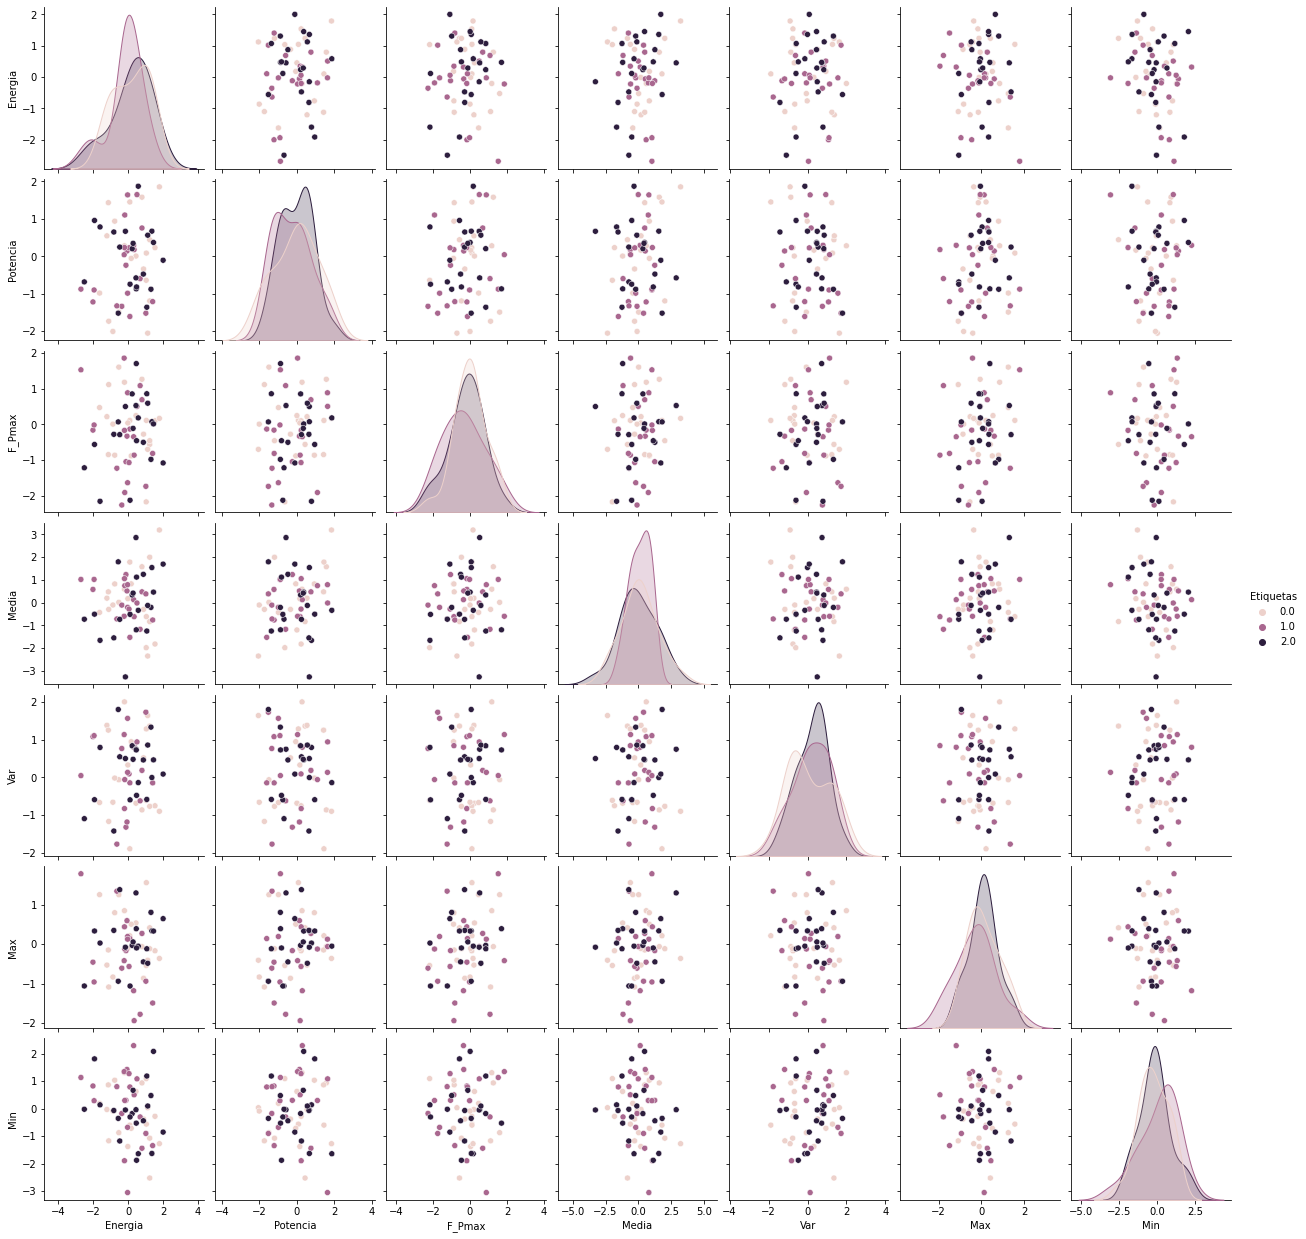

In [26]:
sns.pairplot(df, hue="Etiquetas")